<a href="https://colab.research.google.com/github/sebi061/VideoAdEngagement/blob/main/3_Analysis/2_Car_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Installations ###
#####################

# xg boost
!pip install xgboost

# shap
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.8 MB/s eta 0:00:00


In [ ]:
### Import relevant packages ###
################################

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix

In [ ]:
### Set data directory
##################

# connect to drive
from google.colab import drive
drive.mount('/content/drive')

# set data directory
data_dir_feat =  '/content/drive/MyDrive/VideoAdEngagement/1_Extracted_Data/Extracted_Features'
data_dir_stat =  '/content/drive/MyDrive/VideoAdEngagement/1_Downloaded_Data/3_Engagement_Statistics'

Mounted at /content/drive


In [ ]:
### Load and concat all feature files ###
#########################################

# define function
def load_concat_df(level, files):
  for i, file in enumerate(files):
    if i==0:
      df_final = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)
    else:
      df_additional = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)

      df_final = pd.concat([df_final, df_additional], ignore_index=True, axis = 0)

  return df_final


# files
files = ['hyundai', 'porsche', 'audi', 'bmw',
         'vw', 'mercedes', 'honda', 'ford',
         'skoda', 'ferrari']


# load feature dfs
low_level_df = load_concat_df(level = 'low_level', files = files)
mid_level_df = load_concat_df(level = 'mid_level', files = files)
high_level_df = load_concat_df(level = 'high_level', files = files)
object_level_df = load_concat_df(level = 'object', files = files)

# concat all
df_feat = low_level_df.merge(mid_level_df, on='video_id').merge(object_level_df, on='video_id').merge(high_level_df, on = 'video_id')

In [ ]:
### Load stats file and merge with feature file ###
###################################################

# load
df_stats = pd.read_csv(os.path.join(data_dir_stat, 'df_cars_stats.csv'), index_col = 0)

# merge
df_full = df_stats.merge(df_feat, on = 'video_id')

{'mercedes': 0.05727768733844177, 'skoda': 0.04208681360892751, 'vw': 0.051199967520731596, 'honda': 0.025077718343563697, 'ferrari': 0.10696004568159122, 'bmw': 0.04486897480702443, 'hyundai': 0.04875188961949696, 'ford': 0.05211933642036357, 'audi': 0.07846626775446079, 'porsche': 0.051860653329514485}
{'mercedes': 0.024318938975587484, 'skoda': 0.013687051542044385, 'vw': 0.019449579151675733, 'honda': 0.019140221830587893, 'ferrari': 0.025583332407194903, 'bmw': 0.008604650359242155, 'hyundai': 0.061494727334989334, 'ford': 0.013492355656677002, 'audi': 0.02556331748442063, 'porsche': 0.014571599142867537}


<Axes: ylabel='Density'>

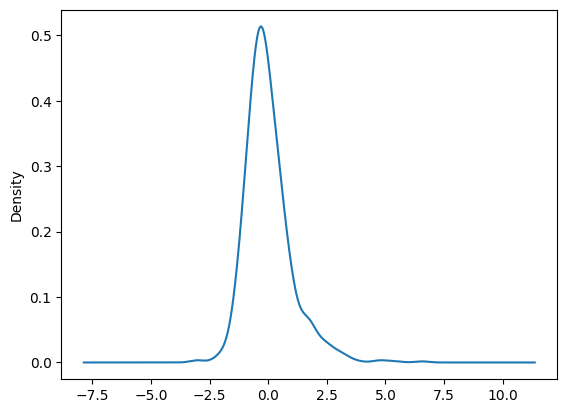

In [ ]:
### Normalization accross all brands ###
########################################

# extract brand means
brand_means = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].mean() for b in set(df_full.brand)}
print(brand_means)

# extract brand stds
brand_std = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].std() for b in set(df_full.brand)}
print(brand_std)

# normalization function
def mu_sig_normalization(example):
  norm_value = (example['eng_score'] - brand_means[example['brand']]) / brand_std[example['brand']]
  #norm_value = example['eng_score'] - brand_means[example['brand']]

  return norm_value

# apply normalization
df_full['norm_eng_score'] = df_full.apply(mu_sig_normalization, axis = 1)

# plot
df_full['norm_eng_score'].plot.kde(bw_method=0.3)

In [ ]:
### Normalize all features accross brands ###
#############################################

# create copy to store normalized values to
df_full_norm = df_full[['video_id', 'brand', 'views', 'likes', 'comments', 'eng_score', 'norm_eng_score']].copy()

# function to subtract feature mean per brand
def feature_mu_sig_norm(example):

  # option 1: mean sigma normalization
  if stds[example[0]] == 0:
    result = example[1] - means[example[0]]

  else:
     result = (example[1] - means[example[0]]) / stds[example[0]]

  # option 2: mu mormalization
  #result = example[1] - means[example[0]]

  return result

# loop over all features to normalize by brand mean
for feat in df_full.columns[6:-1]: # strat at 6

  # get feature mean values per brand
  means = {b: df_full.loc[df_full['brand'] == b, feat].mean() for b in set(df_full.brand)}
  stds =  {b: df_full.loc[df_full['brand'] == b, feat].std() for b in set(df_full.brand)}

  # store to new dataframe
  df_additional = pd.DataFrame({feat:df_full[['brand', feat]].apply(feature_mu_sig_norm, axis = 1)})
  df_full_norm = pd.concat([df_full_norm, df_additional], axis = 1)

In [ ]:
### Define engagement classes ###
#################################

# wrote function
def eng_classes(example):
  if example['norm_eng_score'] < df_full_norm['norm_eng_score'].quantile(1/3):
    cls = 'low'

  elif example['norm_eng_score'] >= df_full_norm['norm_eng_score'].quantile(2/3):
    cls = 'high'

  else:
    cls = 'mid'

  return cls

# apply to df
df_full_norm['eng_class'] = df_full_norm.apply(eng_classes, axis = 1)

# check walue counts
df_full_norm['eng_class'].value_counts()

low     265
high    265
mid     264
Name: eng_class, dtype: int64

# Classification of 3 engagement classes

In [ ]:
### Select all features from dataframe ###
##########################################

ds = df_full_norm.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'mid', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs.best_params_)

# best accuracy score
print(gs.best_score_)

{'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.6000000000000001, 'eta': 0.6000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7999999999999999}
0.5027027027027028


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs.best_params_
model = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model.fit(X_train, y_train)

# final prediction on test set
y_pred = model.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy mid engagement class: {per_class_acc[1] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[2] * 100:.2f} %")

Total accuracy: 47.70 %
Accuracy low engagement class: 54.29 %
Accuracy mid engagement class: 41.11 %
Accuracy high engagement class: 49.37 %


# Classification of high and low engagment class - 2 way

In [ ]:
### Remove middle class to get clearer distinction ###
######################################################

df_full_norm_2 = df_full_norm.loc[df_full_norm['eng_class'] != 'mid'].reset_index(drop = True)

In [ ]:
### Model fitting and cross validation ###
##########################################
# https://www.anyscale.com/blog/how-to-tune-hyperparameters-on-xgboost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

ds = df_full_norm_2.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_2 = RandomizedSearchCV(estimator=xgbclf_2,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_2.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_2.best_params_)

# best accuracy score
print(gs_2.best_score_)

{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.5000000000000001, 'eta': 0.8000000000000003, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.6}
0.6495978669464114


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs_2.best_params_
model_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_2.fit(X_train, y_train)

# final prediction on test set
y_pred = model_2.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 69.81 %
Accuracy low engagement class: 68.35 %
Accuracy high engagement class: 71.25 %


In [ ]:
### Permutation feature importance ###
######################################
from sklearn.inspection import permutation_importance
r = permutation_importance(model_2, X_test, y_test, n_repeats=10, scoring = "accuracy", random_state=0)
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{df_full_norm.columns[7:-1][i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

p_sound_breathing0.026 +/- 0.011
p_action_singing0.021 +/- 0.007
p_scene_factory0.019 +/- 0.008
p_action_smiling/grinning0.018 +/- 0.005
p_action_bending0.015 +/- 0.004
p_action_cracking0.013 +/- 0.006
p_action_painting0.013 +/- 0.006
p_action_gambling0.013 +/- 0.003
p_sound_mouse_click0.011 +/- 0.005
p_scene_auditorium0.010 +/- 0.003
p_action_drawing0.009 +/- 0.004
p_sound_pig0.009 +/- 0.004
sc_part_20.008 +/- 0.004
p_action_roaring0.008 +/- 0.003
p_action_skipping0.006 +/- 0.003
sbw_part_30.006 +/- 0.002


# Train on low level, semantic and psychological features individually

In [ ]:
### low level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_low = df_full_norm_2.iloc[:, 7:34]

In [ ]:
# select x and y variables
X, y = ds_low, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_low = RandomizedSearchCV(estimator=xgbclf_low,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_low.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_low = gs_low.best_params_
model_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_low['learning_rate'],
                     max_depth = best_parameters_low['max_depth'],
                     n_estimators = best_parameters_low['n_estimators'],
                     min_child_weight = best_parameters_low['min_child_weight'],
                     colsample_bytree = best_parameters_low['colsample_bytree'],
                     colsample_bylevel = best_parameters_low['colsample_bylevel'],
                     subsample = best_parameters_low['subsample'],
                     eta = best_parameters_low['eta'],
                     gamma = best_parameters_low['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_low.fit(X_train, y_train)

# final prediction on test set
y_pred = model_low.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 52.83 %
Accuracy low engagement class: 51.90 %
Accuracy high engagement class: 53.75 %


In [ ]:
### Mid level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_mid = df_full_norm_2.iloc[:, 35:506]

In [ ]:
# select x and y variables
X, y = ds_mid, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_mid = RandomizedSearchCV(estimator=xgbclf_mid,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_mid.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_mid = gs_mid.best_params_
model_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_mid['learning_rate'],
                     max_depth = best_parameters_mid['max_depth'],
                     n_estimators = best_parameters_mid['n_estimators'],
                     min_child_weight = best_parameters_mid['min_child_weight'],
                     colsample_bytree = best_parameters_mid['colsample_bytree'],
                     colsample_bylevel = best_parameters_mid['colsample_bylevel'],
                     subsample = best_parameters_mid['subsample'],
                     eta = best_parameters_mid['eta'],
                     gamma = best_parameters_mid['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_mid.fit(X_train, y_train)

# final prediction on test set
y_pred = model_mid.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 66.04 %
Accuracy low engagement class: 65.82 %
Accuracy high engagement class: 66.25 %


In [ ]:
### High level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_high = df_full_norm_2.iloc[:, 507:-1]

In [ ]:
# select x and y variables
X, y = ds_high, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_high = RandomizedSearchCV(estimator=xgbclf_high,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_high.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_high = gs_high.best_params_
model_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_high['learning_rate'],
                     max_depth = best_parameters_high['max_depth'],
                     n_estimators = best_parameters_high['n_estimators'],
                     min_child_weight = best_parameters_high['min_child_weight'],
                     colsample_bytree = best_parameters_high['colsample_bytree'],
                     colsample_bylevel = best_parameters_high['colsample_bylevel'],
                     subsample = best_parameters_high['subsample'],
                     eta = best_parameters_high['eta'],
                     gamma = best_parameters_high['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_high.fit(X_train, y_train)

# final prediction on test set
y_pred = model_high.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 58.49 %
Accuracy low engagement class: 56.96 %
Accuracy high engagement class: 60.00 %


# Cumputing SHAP feature contributions

In [ ]:
# import libraries
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# sort the normalized engagement scores
s = df_full_norm_2['norm_eng_score'].argsort()

In [ ]:
# sample the 50 observations with the highest and 50 observations with the lowest engagement scores
high_low = list(s[:50]) + list(s[-50:])
len(high_low)

100

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


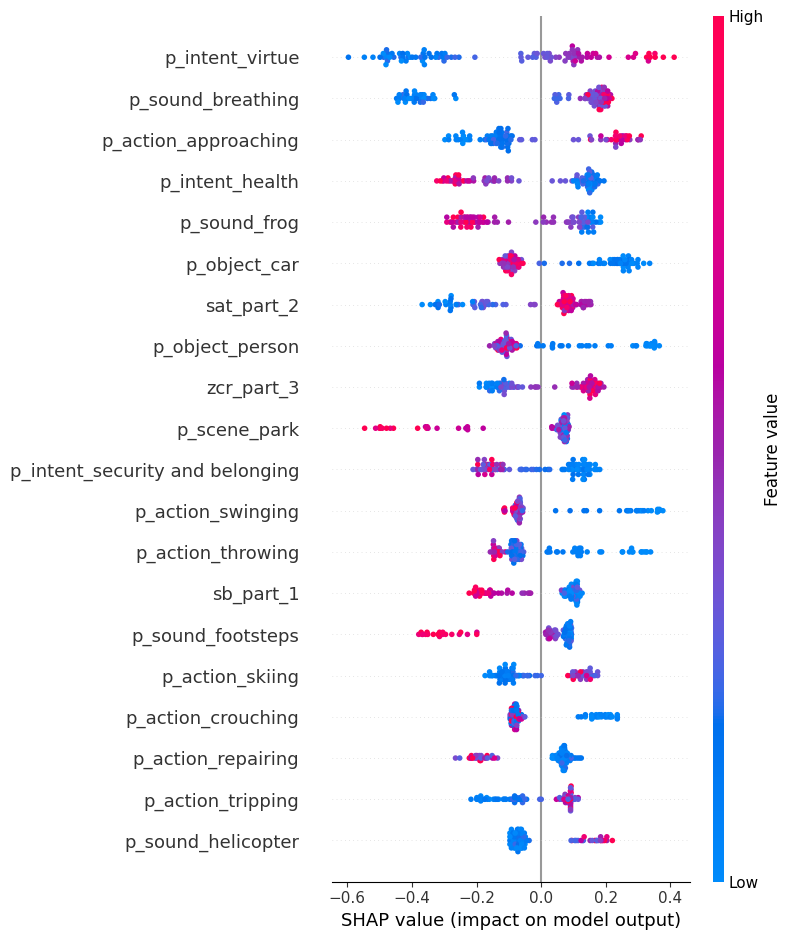

In [ ]:
X_sampled = ds.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape3.png')

# Pca

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# low colour
pca = PCA(n_components=3, random_state = 42)
ds_low_colour = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 7:16]), columns = [f"colour_pc_{i}" for i in range(3)])
ds_low_colour

,colour_pc_0,colour_pc_1,colour_pc_2
0,1.286138,-0.293516,-0.829496
1,-1.677704,-1.874331,-0.584752
2,-1.341317,-3.742251,-1.318822
3,-1.034494,-3.697538,-1.257379
4,0.248120,1.974692,-0.556176
...,...,...,...
525,1.975823,-0.062381,-0.281404
526,-2.072708,0.547184,-0.582323
527,-1.209609,2.919882,1.196987
528,5.300116,0.420700,-0.852472


In [ ]:
# low level dynamics
pca = PCA(n_components=2, random_state = 42)
ds_low_dyn = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 16:22]), columns = [f"dynamics_pc_{i}" for i in range(2)])
ds_low_dyn

,dynamics_pc_0,dynamics_pc_1
0,2.438187,0.778245
1,-2.323045,1.027950
2,-2.299709,0.527404
3,-2.289534,0.529566
4,-1.513012,-0.491077
...,...,...
525,0.180676,-0.702717
526,-0.785192,-1.109713
527,0.188802,0.196979
528,-0.553797,-0.172905


In [ ]:
# low level audio
pca = PCA(n_components=4, random_state = 42)
ds_low_audio = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 22:34]), columns = [f"audio_pc_{i}" for i in range(4)])
ds_low_audio

,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3
0,2.032122,-2.492006,-0.024554,0.018979
1,-3.628339,0.017132,-0.524051,-0.722560
2,-0.897768,0.641658,-0.552927,-0.516608
3,-0.915464,0.599472,-0.608773,-0.527364
4,3.361432,1.424558,-0.479121,-0.098904
...,...,...,...,...
525,-1.660530,-4.099502,0.103351,-0.569045
526,1.658228,1.246769,-0.219308,-1.691127
527,-2.861782,-2.018063,-0.795279,-0.961325
528,5.306242,-0.325152,-0.273225,0.021395


In [ ]:
# mid action
pca = PCA(n_components=10, random_state = 42)
ds_mid_action = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 34:326]), columns = [f"action_pc_{i}" for i in range(10)])
ds_mid_action

,action_pc_0,action_pc_1,action_pc_2,action_pc_3,action_pc_4,action_pc_5,action_pc_6,action_pc_7,action_pc_8,action_pc_9
0,-2.361954,4.181192,-4.577295,-2.298988,-3.894256,-2.317058,-2.079091,-1.881266,-3.047658,5.228039
1,-3.255727,-2.402935,5.014898,5.095073,-0.575278,-0.527532,2.251798,3.240193,1.444630,-0.693648
2,5.789534,-1.552243,7.142698,2.607766,-4.072781,-3.278469,7.535787,0.205572,-3.415651,-1.536392
3,6.200576,-8.840681,-2.256237,-0.029236,-3.446266,-3.665258,3.836471,4.690884,-2.911499,0.956269
4,1.641379,8.488293,4.759965,-4.167792,-1.291039,-3.476058,-2.466481,2.605732,0.225885,-2.171786
...,...,...,...,...,...,...,...,...,...,...
525,-2.151247,-0.599396,-3.118528,-0.533164,-0.725883,1.303589,-0.083605,-4.213144,-2.951049,-0.491477
526,-1.567955,4.568985,-5.803635,-1.036020,-0.591431,3.163165,1.813708,1.252841,-0.103827,-1.456854
527,10.973890,-2.340192,-3.451635,2.966826,-0.886870,2.145961,2.083751,-1.105181,1.193544,0.529713
528,0.265160,-4.514616,-0.662688,-1.481417,-1.418364,-4.016146,0.585311,0.055467,-1.689412,-0.510740


In [ ]:
# mid face
pca = PCA(n_components=4, random_state = 42)
ds_mid_face = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 326:333]), columns = [f"face_pc_{i}" for i in range(4)])
ds_mid_face

,face_pc_0,face_pc_1,face_pc_2,face_pc_3
0,0.109830,-0.631128,-0.545360,0.320827
1,0.038809,-0.801350,0.229654,-0.629891
2,0.046122,-0.998742,0.404417,-0.445122
3,4.317390,3.559235,1.745208,0.042274
4,0.053303,-0.534194,-1.503026,0.546890
...,...,...,...,...
525,-1.110294,0.530744,0.247888,0.252987
526,-1.110294,0.530744,0.247888,0.252987
527,-1.110294,0.530744,0.247888,0.252987
528,-1.110294,0.530744,0.247888,0.252987


In [ ]:
# mid scenes
pca = PCA(n_components=10, random_state = 42)
ds_mid_scenes = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 333:372]), columns = [f"scenes_pc_{i}" for i in range(10)])
ds_mid_scenes

,scenes_pc_0,scenes_pc_1,scenes_pc_2,scenes_pc_3,scenes_pc_4,scenes_pc_5,scenes_pc_6,scenes_pc_7,scenes_pc_8,scenes_pc_9
0,-2.105788,-1.321147,-0.537344,2.120448,-0.602471,0.668737,0.266543,0.788845,0.499927,-0.307103
1,-2.049948,-0.500394,0.088692,-0.010783,0.728567,0.249508,0.119687,-0.515456,0.470678,-0.489212
2,-2.789039,0.399983,0.116973,0.277915,0.249151,0.953057,0.523715,0.288367,0.236359,-0.183162
3,-2.822914,0.199587,0.251835,0.423296,0.193668,0.859333,0.249043,0.306887,0.209254,-0.144305
4,1.496180,4.660536,-1.726042,-0.965058,-0.276826,-0.919735,-0.228391,1.299308,0.715760,-0.073000
...,...,...,...,...,...,...,...,...,...,...
525,0.119010,0.055509,0.470570,0.471498,-0.415615,0.254167,0.222484,0.407563,-0.328065,-0.616747
526,-0.272685,-0.232033,0.221839,-0.027240,-0.693854,0.924094,0.599685,0.374902,-0.373590,-0.640095
527,3.068693,-0.350297,0.337765,-0.520640,-0.102692,-0.465212,0.253475,0.258374,-0.130856,-0.539729
528,-1.712122,1.570514,-0.495394,0.121056,-0.325941,0.572156,1.141302,-0.387940,-0.155080,-1.365997


In [ ]:
# mid sounds
pca = PCA(n_components=10, random_state = 42)
ds_mid_sounds = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 372:426]), columns = [f"sounds_pc_{i}" for i in range(10)])

In [ ]:
# mid objects
pca = PCA(n_components=20, random_state = 42)
ds_mid_objects = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 426:506]), columns = [f"objects_pc_{i}" for i in range(20)])

In [ ]:
# high intent
pca = PCA(n_components=3, random_state = 42)
ds_high_intent = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 506:515]), columns = [f"intent_pc_{i}" for i in range(3)])
ds_high_intent

,intent_pc_0,intent_pc_1,intent_pc_2
0,-0.609747,-0.106094,-1.031897
1,2.876747,-0.132156,-0.532761
2,-0.577488,-0.258887,-0.490128
3,1.081616,0.000310,-0.276336
4,-0.930566,2.035598,1.816761
...,...,...,...
525,-1.900375,1.627193,0.424556
526,-0.921037,-0.488926,0.066969
527,2.161092,-0.673019,0.270429
528,-2.203971,-1.210476,1.418057


In [ ]:
# high mem
ds_high_mem = df_full_norm_2.iloc[:, [515]]
ds_high_mem

,mem_score
0,0.505115
1,1.554302
2,1.535162
3,1.515353
4,-1.478349
...,...
525,-0.067419
526,0.154376
527,-0.947124
528,-0.824375


In [ ]:
# high audio mood
pca = PCA(n_components=2, random_state = 42)
ds_high_audiomood = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 516:-1]), columns = [f"audiomood_pc_{i}" for i in range(2)])
ds_high_audiomood

,audiomood_pc_0,audiomood_pc_1
0,1.707989,0.900889
1,-2.899668,-1.158801
2,0.482976,0.539631
3,0.699014,1.097858
4,2.400381,-1.952909
...,...,...
525,-0.921782,-0.001737
526,2.592524,-0.981361
527,-1.657969,-1.016887
528,-0.358225,0.687585


In [ ]:
# combining all
ds_pca = pd.concat([ds_low_colour, ds_low_dyn, ds_low_audio, ds_mid_action, ds_mid_face, ds_mid_objects, ds_mid_scenes, ds_mid_sounds, ds_high_intent, ds_high_mem, ds_high_audiomood], ignore_index=False, axis = 1)
ds_pca

,colour_pc_0,colour_pc_1,colour_pc_2,dynamics_pc_0,dynamics_pc_1,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3,action_pc_0,...,sounds_pc_6,sounds_pc_7,sounds_pc_8,sounds_pc_9,intent_pc_0,intent_pc_1,intent_pc_2,mem_score,audiomood_pc_0,audiomood_pc_1
0,1.286138,-0.293516,-0.829496,2.438187,0.778245,2.032122,-2.492006,-0.024554,0.018979,-2.361954,...,0.031168,-0.996910,-0.581599,-1.183210,-0.609747,-0.106094,-1.031897,0.505115,1.707989,0.900889
1,-1.677704,-1.874331,-0.584752,-2.323045,1.027950,-3.628339,0.017132,-0.524051,-0.722560,-3.255727,...,0.371345,0.242023,0.881711,0.136266,2.876747,-0.132156,-0.532761,1.554302,-2.899668,-1.158801
2,-1.341317,-3.742251,-1.318822,-2.299709,0.527404,-0.897768,0.641658,-0.552927,-0.516608,5.789534,...,0.332675,-0.479705,1.217379,-1.951977,-0.577488,-0.258887,-0.490128,1.535162,0.482976,0.539631
3,-1.034494,-3.697538,-1.257379,-2.289534,0.529566,-0.915464,0.599472,-0.608773,-0.527364,6.200576,...,0.164910,-0.335965,1.525490,-1.730153,1.081616,0.000310,-0.276336,1.515353,0.699014,1.097858
4,0.248120,1.974692,-0.556176,-1.513012,-0.491077,3.361432,1.424558,-0.479121,-0.098904,1.641379,...,-2.344678,0.803274,-0.549884,0.342571,-0.930566,2.035598,1.816761,-1.478349,2.400381,-1.952909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1.975823,-0.062381,-0.281404,0.180676,-0.702717,-1.660530,-4.099502,0.103351,-0.569045,-2.151247,...,-0.346824,-0.842262,0.396483,-2.575569,-1.900375,1.627193,0.424556,-0.067419,-0.921782,-0.001737
526,-2.072708,0.547184,-0.582323,-0.785192,-1.109713,1.658228,1.246769,-0.219308,-1.691127,-1.567955,...,-1.136235,1.185706,-0.231865,1.260343,-0.921037,-0.488926,0.066969,0.154376,2.592524,-0.981361
527,-1.209609,2.919882,1.196987,0.188802,0.196979,-2.861782,-2.018063,-0.795279,-0.961325,10.973890,...,-4.053047,0.981094,3.393741,-1.938360,2.161092,-0.673019,0.270429,-0.947124,-1.657969,-1.016887
528,5.300116,0.420700,-0.852472,-0.553797,-0.172905,5.306242,-0.325152,-0.273225,0.021395,0.265160,...,-0.521363,-0.120100,-1.064420,1.016468,-2.203971,-1.210476,1.418057,-0.824375,-0.358225,0.687585


# Fit 2 way classification model to the features reduced in dimensions

In [ ]:
### train test split ###
########################

# select x and y variables
X, y = ds_pca, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_3 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_3 = RandomizedSearchCV(estimator=xgbclf_3,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_3.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_3.best_params_)

# best accuracy score
print(gs_3.best_score_)

{'subsample': 0.6, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.8000000000000003, 'eta': 0.4000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}
0.6469534050179212


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs_3.best_params_
model_pca = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_pca.fit(X_train, y_train)

# final prediction on test set
y_pred = model_pca.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 64.78 %
Accuracy low engagement class: 65.82 %
Accuracy high engagement class: 63.75 %


 # Shap

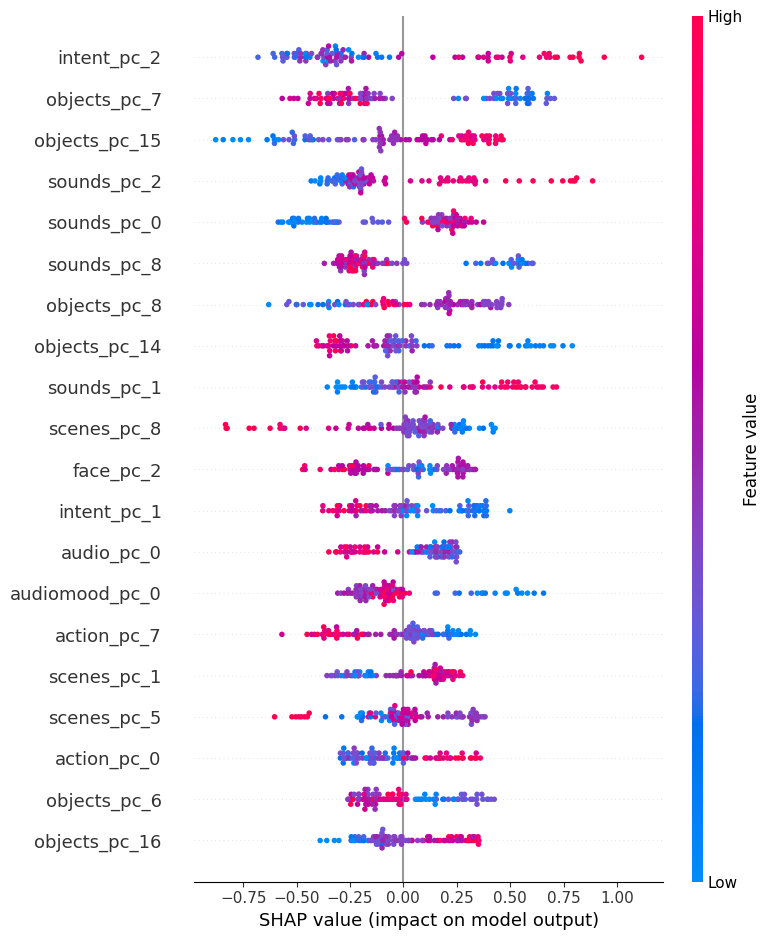

In [ ]:
X_sampled = ds_pca.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_pca)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape4.png')